In [1]:
!apt-get -y install google-chrome-stable

Reading package lists... Done
Building dependency tree       
Reading state information... Done
google-chrome-stable is already the newest version (98.0.4758.102-1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [2]:
chrome_driver_version = !curl -get http://chromedriver.storage.googleapis.com/LATEST_RELEASE
chrome_driver_version = chrome_driver_version[-1]
url = f'http://chromedriver.storage.googleapis.com/{chrome_driver_version}/chromedriver_linux64.zip'
url

'http://chromedriver.storage.googleapis.com/98.0.4758.102/chromedriver_linux64.zip'

In [3]:
!wget -O /tmp/chromedriver.zip $url

--2022-02-28 12:32:07--  http://chromedriver.storage.googleapis.com/98.0.4758.102/chromedriver_linux64.zip
Resolving chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)... 34.64.4.112, 2404:f340:10:1803::2010
Connecting to chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)|34.64.4.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10229802 (9.8M) [application/zip]
Saving to: ‘/tmp/chromedriver.zip’

/tmp/chromedriver.z 100%[===================>]   9.76M  6.77MB/s    in 1.4s    

2022-02-28 12:32:09 (6.77 MB/s) - ‘/tmp/chromedriver.zip’ saved [10229802/10229802]



In [4]:
!unzip -o /tmp/chromedriver.zip chromedriver -d /usr/local/bin/

Archive:  /tmp/chromedriver.zip
  inflating: /usr/local/bin/chromedriver  


In [5]:
import pandas as pd 
import os
from hanspell import spell_checker
import requests
from urllib import parse
import json
from multiprocessing.dummy import Process, Queue, Pool, Manager
import math
import re
from time import process_time, sleep
from ckonlpy.tag import Twitter
from nltk import ngrams
from os import getpid
from selenium import webdriver
from IPython import display
from base64 import b64decode
from google.cloud import vision
import io
from PIL import Image
import csv
import uuid
import time

In [6]:
schoolNoticeListPath = './train_data'
schoolNoticeListPath = os.path.join(schoolNoticeListPath, 'school-notice.csv')
schoolNoticeListPath

'./train_data/school-notice.csv'

In [7]:
schoolNoticeList = pd.read_csv(schoolNoticeListPath)
schoolNoticeList.head()

,idx,url,category,date
0,5298,https://web.kangnam.ac.kr/menu/board/info/f190...,학습/상담,22.02.28
1,5297,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.28
2,5296,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.27
3,5295,https://web.kangnam.ac.kr/menu/board/info/f190...,장학,22.02.25
4,5294,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25


In [8]:
schoolNoticeList.dtypes

idx          int64
url         object
category    object
date        object
dtype: object

In [9]:
schoolNoticeList.size

21192

In [10]:
options = webdriver.chrome.options.Options()
options.add_argument("--no-sandbox")
options.add_argument("--disable-setuid-sandbox")
options.add_argument("--disable-extensions")
options.add_argument('headless')
options.add_argument('window-size=1920x1080')
options.add_argument("disable-gpu")
driver = webdriver.Chrome(chrome_options=options)

driver.get("https://httpstat.us/200")

if "200 OK" in driver.page_source:
    print('Selenium successfully opened with Chrome (under the Xvfb display) and navigated to "https://httpstat.us/200", you\'re all set!')
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


Selenium successfully opened with Chrome (under the Xvfb display) and navigated to "https://httpstat.us/200", you're all set!


In [11]:
url = schoolNoticeList['url'][0]
url

'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=False&encMenuSeq=b46b6e20bc53a0234ac9fc9a238b113a&encMenuBoardSeq=39b3e9dcb9fc1c0bb4fb49abf52ebaca'

In [12]:
driver.get(url)

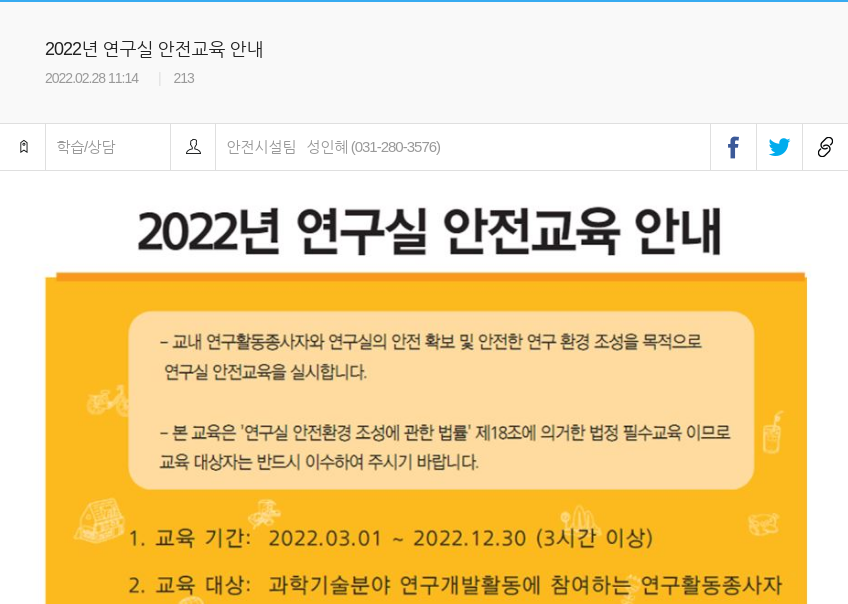

In [13]:
assert driver.page_source is not None
content = driver.find_element_by_css_selector('#sub_content_wrap > div > div > div.col-xs-12.col-md-9 > div > div.cont > div > div > div.ul_respon.tbl_wtite.tbl_write02')
display.Image(b64decode(content.screenshot_as_base64))

In [14]:
body = content.find_element_by_css_selector('div.tbody > ul:nth-child(2)')
body.get_attribute('innerHTML')#sub_content_wrap > div > div > div.col-xs-12.col-md-9 > div > div.cont > div > div > div.ul_respon.tbl_wtite.tbl_write02 > 

'<li class="first last odd li_index0 li_respon w100"><div class="inner_txt"><div class="tbl_view cke_editable cke_editable_themed cke_contents_ltr"><p class="contents_add_one1" style="display:none;">연구실 안전교육</p><p class="contents_add_one2" style="display:none;">안전시설팀</p><p><img alt="" src="/comm/cmnFile/image.do?encSvrFileNm=505d616b62e9cf71e0c8acd58f452006bb1f0cdaee5b57e7704b295729ff8e4bdbe35af3bfecaa94becbad2c752178036043010e95760db1d231ae65fe723180"></p><p>&nbsp;</p></div></div></li>'

In [15]:
body.text.strip()

''

In [16]:
'img' in body.get_attribute('innerHTML')

True

In [17]:
img_list = [img_tag.get_attribute('src') for img_tag in body.find_elements_by_css_selector('img')]
img_list

['https://web.kangnam.ac.kr/comm/cmnFile/image.do?encSvrFileNm=505d616b62e9cf71e0c8acd58f452006bb1f0cdaee5b57e7704b295729ff8e4bdbe35af3bfecaa94becbad2c752178036043010e95760db1d231ae65fe723180']

In [18]:
'base64' in img_list[0]

False

In [19]:
schoolNoticeSrcListPath = os.path.join('./train_data/src', f'{uuid.uuid1()}.png')
os.makedirs('./train_data/src', exist_ok=True)
img_data = requests.get(img_list[0]).content
with open(schoolNoticeSrcListPath, 'wb') as handler:
    handler.write(img_data)

In [20]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·\s]', '', inputString)
    return text_rmv

In [21]:
def export_notice_text(body):
    return body.text

In [22]:
def export_title_text(body):
    return clean_text(body.find_element_by_css_selector('div.tblw_subj.nanum').text.strip())

![img](https://user-images.githubusercontent.com/16532326/155954767-85a93d5c-2878-4abd-908b-aa4a01929ed9.png)

게시판에 프로토콜이 `http`, `https` 형식이 아닌 `file` 프로토콜이 포함된 이미지가 있음

https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=False&encMenuSeq=c5dc4b1d7b4dd402e5e6a7a8471eb55c&encMenuBoardSeq=12aa97bcda27ea9eaf76f5b20cbbf1c0

In [23]:
train_data_src = './train_data/src'
os.makedirs(train_data_src, exist_ok=True)

def export_notice_img_list(body):
    img_saved_path_list = []
    if 'img' in body.get_attribute('innerHTML'):
        img_list = [img_tag.get_attribute('src') for img_tag in body.find_elements_by_css_selector('img')]
#         print('img_list', img_list)
        for img_src in img_list:
            srcPath = os.path.join(train_data_src, f'{uuid.uuid1()}.png')
#             print(srcPath, img_saved_path_list)
            if 'base64' in img_src:
#                 print('append?', img_saved_path_list.append(srcPath), img_saved_path_list)
                with open(srcPath, "wb") as f:
                    f.write(b64decode(re.search(r'base64,(.*)', img_src).group(1)))
                img_saved_path_list.append(srcPath)
#                 print(srcPath, img_saved_path_list)
            elif 'http' in img_src:
                try:
                    img_data = requests.get(img_src).content
                    with open(srcPath, 'wb') as handler:
                        handler.write(img_data)
                    img_saved_path_list.append(srcPath)
                except Exception as e:
                    print(f'Cannot download img from url: {img_src}', e)
#                 print(srcPath, img_saved_path_list)
    return img_saved_path_list

In [24]:
def export_notice_data(driver, url, idx = None):
    if driver is None or url is None:
        print(f'idx: {idx}, driver or url is None')
        return (idx, None, None, None)
    driver.get(url)
    
    if driver.page_source is None:
        print(f'idx: {idx}, page_source is None')
        return (idx, None, None, None)
    
    content = driver.find_element_by_css_selector('#sub_content_wrap > div > div > div.col-xs-12.col-md-9 > div > div.cont > div > div > div.ul_respon.tbl_wtite.tbl_write02')
    
    body = content.find_element_by_css_selector('div.tbody > ul:nth-child(2)')
#     print(content.text, 'body', body.text)
    return (idx, export_title_text(content), export_notice_text(body), export_notice_img_list(body))

In [25]:
assert len(export_notice_data(driver, 'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=false&encMenuSeq=c5dc4b1d7b4dd402e5e6a7a8471eb55c&encMenuBoardSeq=1db853c16158bdae31c09d146d4571dc')[3]) == 4
assert len (export_notice_data(driver, 'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=false&encMenuSeq=b46b6e20bc53a0234ac9fc9a238b113a&encMenuBoardSeq=39b3e9dcb9fc1c0bb4fb49abf52ebaca')[3]) == 1

In [26]:
result = export_notice_data(driver, 'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=false&encMenuSeq=c5dc4b1d7b4dd402e5e6a7a8471eb55c&encMenuBoardSeq=a9e53dcab66d25012cdc87c13d1c9c1d')
# (None, len(result[1]), len(result[2]), len(result[3]))
assert (None, len(result[1]), len(result[2]), len(result[3])) == (None, 26, 1422, 0)

In [27]:
schoolNoticeList[:10]

,idx,url,category,date
0,5298,https://web.kangnam.ac.kr/menu/board/info/f190...,학습/상담,22.02.28
1,5297,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.28
2,5296,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.27
3,5295,https://web.kangnam.ac.kr/menu/board/info/f190...,장학,22.02.25
4,5294,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25
5,5293,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25
6,5292,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25
7,5291,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.24
8,5290,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.24
9,5289,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.23


In [28]:
t1_start = time.perf_counter()
for idx in range(10):
    export_notice_data(driver, schoolNoticeList['url'][idx], idx)
t1_stop = time.perf_counter()
takeTime = round(t1_stop - t1_start, 2)
print(f'time: {takeTime:>8}s')

time:     10.0s


In [50]:
reqNum = 5
driver_pool = []

for idx in range(reqNum):
    options = webdriver.chrome.options.Options()
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-setuid-sandbox")
    options.add_argument("--disable-extensions")
    options.add_argument('headless')
    options.add_argument('window-size=1920x1080')
    options.add_argument("disable-gpu")
    driver = webdriver.Chrome(chrome_options=options)
    driver_pool.append(driver)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


In [51]:
processQueue = Queue()
while not processQueue.empty():
    try:
        processQueue.get(False)
    except Empty:
        continue
#     processQueue.task_done()
processQueue.qsize()

0

In [52]:
lastProcessPercentage = 0
dataSize = len(schoolNoticeList['idx'])
t1_start = time.perf_counter()
debug = False
offset = 3998
TIMEOUT = 10

for pid in range(math.ceil(dataSize / reqNum)):
    start = pid * reqNum + 1 + offset
    
    if (start / dataSize) * 100 - lastProcessPercentage > 5:
        lastProcessPercentage = round((start / dataSize) * 100, 2)
        t1_stop = time.perf_counter()
        takeTime = round(t1_stop - t1_start, 2)
        print(f'process...{lastProcessPercentage:>6}% time: {takeTime:>8}s')
    
    if start + reqNum > dataSize:
        end = dataSize
    else:
        end = start + reqNum
    processList = []
    print(f'{start:>5} ~ {end:>5} start!') if debug else None
    with Pool(processes=reqNum) as pool:
#         print('pool start')
        results = [pool.apply_async(export_notice_data, (driver_pool[idx % reqNum], schoolNoticeList['url'][idx], idx)) for idx in range(start, end)]
#         print('result ')
#         sleep(TIMEOUT)
#         pool.terminate()
#         print('terminate', len(results))
        for idx in range(len(results)):
#             print(results[idx].get())
            processQueue.put(results[idx].get())
#         [print(res.get()) for res in results]#processQueue.put
#         print('send queue')
#         print(results[0].get())
    print(f'{start:>5} ~ {end:>5} done! queue size: {processQueue.qsize()}') if debug else None

t1_stop = time.perf_counter()
takeTime = round(t1_stop - t1_start, 2)
print(f'process...100% time: {takeTime:>8}s')

process... 75.48% time:      0.0s
process... 80.48% time:   166.67s
process... 85.49% time:   385.37s
process... 90.58% time:   537.86s
Cannot download img from url: https://intranet.zuminternet.com/images/recruit_img_160906.jpg HTTPSConnectionPool(host='intranet.zuminternet.com', port=443): Max retries exceeded with url: /images/recruit_img_160906.jpg (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
Cannot download img from url: https://intranet.zuminternet.com/images/recruit_banner_160907_est.jpg HTTPSConnectionPool(host='intranet.zuminternet.com', port=443): Max retries exceeded with url: /images/recruit_banner_160907_est.jpg (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
process... 95.58% time:   712.57s
process...100.59% time:  1029.18s
process...105.68% time:  1034.72s
process...110.68% time:  1040.15s
process...115.69% time:  1045.58s
process...120.78% time

지져스 크라이스 퍼센트지가 100%를 넘네 이유가 뭐지

In [62]:
lastProcessPercentage = 0
dataSize = len(schoolNoticeList['idx'])
t1_start = time.perf_counter()
debug = True
offset = 3998
TIMEOUT = 10

for pid in range(math.ceil(dataSize / reqNum)):
    start = pid * reqNum + 1 + offset
    
    if (start / dataSize) * 100 - lastProcessPercentage > 5:
        lastProcessPercentage = round((start / dataSize) * 100, 2)
        t1_stop = time.perf_counter()
        takeTime = round(t1_stop - t1_start, 2)
        print(f'process...{lastProcessPercentage:>6}% time: {takeTime:>8}s')
    
    if start + reqNum > dataSize:
        end = dataSize
    else:
        end = start + reqNum
    processList = []
    print(f'{start:>5} ~ {end:>5} start!') if debug else None
#     with Pool(processes=reqNum) as pool:
# #         print('pool start')
#         results = [pool.apply_async(export_notice_data, (driver_pool[idx % reqNum], schoolNoticeList['url'][idx], idx)) for idx in range(start, end)]
# #         print('result ')
# #         sleep(TIMEOUT)
# #         pool.terminate()
# #         print('terminate', len(results))
#         for idx in range(len(results)):
# #             print(results[idx].get())
#             processQueue.put(results[idx].get())
# #         [print(res.get()) for res in results]#processQueue.put
# #         print('send queue')
# #         print(results[0].get())
    print(f'{start:>5} ~ {end:>5} done! queue size: {processQueue.qsize()}') if debug else None

t1_stop = time.perf_counter()
takeTime = round(t1_stop - t1_start, 2)
print(f'process...100% time: {takeTime:>8}s')

process... 75.48% time:      0.0s
 3999 ~  4004 start!
 3999 ~  4004 done! queue size: 0
 4004 ~  4009 start!
 4004 ~  4009 done! queue size: 0
 4009 ~  4014 start!
 4009 ~  4014 done! queue size: 0
 4014 ~  4019 start!
 4014 ~  4019 done! queue size: 0
 4019 ~  4024 start!
 4019 ~  4024 done! queue size: 0
 4024 ~  4029 start!
 4024 ~  4029 done! queue size: 0
 4029 ~  4034 start!
 4029 ~  4034 done! queue size: 0
 4034 ~  4039 start!
 4034 ~  4039 done! queue size: 0
 4039 ~  4044 start!
 4039 ~  4044 done! queue size: 0
 4044 ~  4049 start!
 4044 ~  4049 done! queue size: 0
 4049 ~  4054 start!
 4049 ~  4054 done! queue size: 0
 4054 ~  4059 start!
 4054 ~  4059 done! queue size: 0
 4059 ~  4064 start!
 4059 ~  4064 done! queue size: 0
 4064 ~  4069 start!
 4064 ~  4069 done! queue size: 0
 4069 ~  4074 start!
 4069 ~  4074 done! queue size: 0
 4074 ~  4079 start!
 4074 ~  4079 done! queue size: 0
 4079 ~  4084 start!
 4079 ~  4084 done! queue size: 0
 4084 ~  4089 start!
 4084 ~  4

 5984 ~  5298 start!
 5984 ~  5298 done! queue size: 0
 5989 ~  5298 start!
 5989 ~  5298 done! queue size: 0
 5994 ~  5298 start!
 5994 ~  5298 done! queue size: 0
 5999 ~  5298 start!
 5999 ~  5298 done! queue size: 0
 6004 ~  5298 start!
 6004 ~  5298 done! queue size: 0
 6009 ~  5298 start!
 6009 ~  5298 done! queue size: 0
 6014 ~  5298 start!
 6014 ~  5298 done! queue size: 0
 6019 ~  5298 start!
 6019 ~  5298 done! queue size: 0
 6024 ~  5298 start!
 6024 ~  5298 done! queue size: 0
 6029 ~  5298 start!
 6029 ~  5298 done! queue size: 0
 6034 ~  5298 start!
 6034 ~  5298 done! queue size: 0
 6039 ~  5298 start!
 6039 ~  5298 done! queue size: 0
 6044 ~  5298 start!
 6044 ~  5298 done! queue size: 0
 6049 ~  5298 start!
 6049 ~  5298 done! queue size: 0
 6054 ~  5298 start!
 6054 ~  5298 done! queue size: 0
 6059 ~  5298 start!
 6059 ~  5298 done! queue size: 0
 6064 ~  5298 start!
 6064 ~  5298 done! queue size: 0
 6069 ~  5298 start!
 6069 ~  5298 done! queue size: 0
 6074 ~  5

 7479 ~  5298 done! queue size: 0
 7484 ~  5298 start!
 7484 ~  5298 done! queue size: 0
 7489 ~  5298 start!
 7489 ~  5298 done! queue size: 0
 7494 ~  5298 start!
 7494 ~  5298 done! queue size: 0
 7499 ~  5298 start!
 7499 ~  5298 done! queue size: 0
 7504 ~  5298 start!
 7504 ~  5298 done! queue size: 0
 7509 ~  5298 start!
 7509 ~  5298 done! queue size: 0
 7514 ~  5298 start!
 7514 ~  5298 done! queue size: 0
 7519 ~  5298 start!
 7519 ~  5298 done! queue size: 0
 7524 ~  5298 start!
 7524 ~  5298 done! queue size: 0
 7529 ~  5298 start!
 7529 ~  5298 done! queue size: 0
 7534 ~  5298 start!
 7534 ~  5298 done! queue size: 0
 7539 ~  5298 start!
 7539 ~  5298 done! queue size: 0
 7544 ~  5298 start!
 7544 ~  5298 done! queue size: 0
 7549 ~  5298 start!
 7549 ~  5298 done! queue size: 0
 7554 ~  5298 start!
 7554 ~  5298 done! queue size: 0
 7559 ~  5298 start!
 7559 ~  5298 done! queue size: 0
 7564 ~  5298 start!
 7564 ~  5298 done! queue size: 0
 7569 ~  5298 start!
 7569 ~  5

 9034 ~  5298 done! queue size: 0
 9039 ~  5298 start!
 9039 ~  5298 done! queue size: 0
 9044 ~  5298 start!
 9044 ~  5298 done! queue size: 0
 9049 ~  5298 start!
 9049 ~  5298 done! queue size: 0
 9054 ~  5298 start!
 9054 ~  5298 done! queue size: 0
 9059 ~  5298 start!
 9059 ~  5298 done! queue size: 0
process...171.08% time:     0.65s
 9064 ~  5298 start!
 9064 ~  5298 done! queue size: 0
 9069 ~  5298 start!
 9069 ~  5298 done! queue size: 0
 9074 ~  5298 start!
 9074 ~  5298 done! queue size: 0
 9079 ~  5298 start!
 9079 ~  5298 done! queue size: 0
 9084 ~  5298 start!
 9084 ~  5298 done! queue size: 0
 9089 ~  5298 start!
 9089 ~  5298 done! queue size: 0
 9094 ~  5298 start!
 9094 ~  5298 done! queue size: 0
 9099 ~  5298 start!
 9099 ~  5298 done! queue size: 0
 9104 ~  5298 start!
 9104 ~  5298 done! queue size: 0
 9109 ~  5298 start!
 9109 ~  5298 done! queue size: 0
 9114 ~  5298 start!
 9114 ~  5298 done! queue size: 0
 9119 ~  5298 start!
 9119 ~  5298 done! queue size:

offset 값 처리가 되어있지 않아 시작값이 틀어지는 문제였음

```
if start < end:
    break
```

로 해결 가능

In [53]:
driver_pool
for driver in driver_pool:
    driver.close()

In [54]:
# while not processQueue.empty():
#     data = processQueue.get(0)
#     print(data)

In [55]:
crawled_data_list = []
while not processQueue.empty():
    data = processQueue.get(0)
    crawled_data_list.append(data)
len(crawled_data_list)

1299

In [56]:
crawled_data_list[:5]

[(3999,
  '취업영문이력서작성법특강',
  '영문이력서 작성법 특강\n 외국계회사나 글로벌 기업에 취업(또는 인턴)을 희망하는 여러분에게 도움을 주고자 다음과 같이 영문이력서 작성법 특강을 마련하였습니다. 이번 특강에서는 외국계회사에 취업하는 방법과 취업성공 know-how를 상세히 안내해 드릴 예정입니다. 관심있는 여러분의 많은 참여를 부탁드립니다.\n - 다 음 -\n 1. 특강 내용 : 영문이력서 및 cover letter작성법, job search, 이메일 작성 및 인터뷰 요령 등\n 2. 특강일 (2회) : 9월 26일(화), 28일(목) 오후 2~5시, 본관 2층 회의실\n 3. 신청 방법 (선착순) : 메일(jeongym@kangnam.ac.kr) 또는 문자로 신청(010-8981-4438)\n 4. 지원 자격 : 본교 2, 3, 4학년 (학과 제한없음)\n 정 영민 교수\nTel: 010-8981-4438, 031-280-3256 (인사관 404-3호)\nEmail: jeongym@kangnam.ac.kr',
  []),
 (4000,
  '채용공고코마스시스템엔지니어인턴모집',
  '1.     모집인원 : 인턴 5명 (시스템 엔지니어 : 총 5명(Unix 2명, x86 3명))\n2.     모집기간 : 2017.09.04 ~ 2017.09.20\n3.     채용기준\n-       학력 : 기졸업자 또는 2018년 2월졸업예정자 가능\n-       전공 : 이공계열관련전공자 우대 (학점 최소 3.5이상/최대4.5기준)\n-       담당업무 : 시스템엔지니어(SE) (Unix 2명, x86 3명)\n-       제출서류 : 입사지원서(첨부양식), 성적증명서, 경력기술서(있을 경우)\n-       처우 : 월 150만원\n-       지역 : 서울지역 근무가능자\n-       본사 위치 : 서울시 종로구 청계천로85 삼일빌딩 17층\n-       병력사항 : 군필(군면제포함)\n-       우대자격증 : RHCSA, Un

In [57]:
crawled_data_list[-5:]

[(5293,
  '2015학년도1학기강우장학회장학생선발안내',
  '2015학년도 1학기 강우장학회 장학생 선발 안내\n  강우장학회는 강남대학교에 재직중인 교직원들이 주축이 되어 1987년 2월에 설립된 장학회로서 매년 학기별로 장학금을 지급하고 있습니다.\n  강우장학회에서는 2015학년도 1학기 장학생을 아래와 같이 선발하고자 하오니 관심 있는 재학생들의 많은 신청 바랍니다.\n - 아 래 -\n 1. 신청기간 : 2015. 3. 9.(월) 09:00 ~ 3. 13.(금) 17:30까지\n2. 신청자격\n 가. 직전학기 성적 평균평점 3.0이상\n 나. 학과(부) 1학기 이상 등록자로서 재학중인자\n3. 지급인원 : ○명\n 4. 지급금액 : 1인당 1,000,000원 이내(일백만원 이내)\n 5. 지급예정일 : 추후 공지\n6. 선발결과발표 : 2015. 3. 23(월), 장학생에게 개별통보 및 교내 홈페이지 공지\n7. 제출서류 :\n가. 신청서(첨부양식)\n나. 성적증명서\n다. 장학금신청사유서 1부\n(장학금을 받아야 할 사유를 A4 용지에 자유롭게 작성하되 부모직업 및 가정 형편, 주택거주형태(자가/전세/월세), 학비조달방법, 학업계획 등 장학금을 받 아야 될 사유를 중심으로 자유롭게 작성함).\n라. 기타 증빙서류(장학금신청사유서에 기술한 내용에 대한 증빙자료가 있을 경우에만 첨부)\n예) 전․월세계약서 사본, 미과세증명서, 기초생활수급대상자증명서, 수상실적증명 등\n8. 서류접수\n- 서비스행정실3(경천관 1층) 박재숭 총무 / 취업정보센터(본관 1층) 주광영 회계\n9. 기타사항\n가. 타장학금 수혜자도 지원할 수 있음(등록금을 초과할 수 없음)\n나. 장학금신청서는 첨부한 파일을 다운로드하여 작성\n10. 문의처 : 전화 031-280-3419(총무), 031-280-3557(회계)\n  첨 부 : 강우장학회 장학금신청서 1부. 끝\n   2015. 3. 5\n  강 우 장 학 회 장',
  []),
 (5294,
  '교외장학20151

In [58]:
json_data = {}
json_data['notice'] = []

In [59]:
for crawl_data in crawled_data_list:
    json_data['notice'].append({
        'idx': crawl_data[0],
        'title': crawl_data[1],
        'body': crawl_data[2],
        'imgs': crawl_data[3]
    })

In [60]:
noticeSize = len(json_data['notice'])

In [61]:
with open(os.path.join('./train_data', f'notice{offset}-{noticeSize}.json'), 'w') as outfile:
    json.dump(json_data, outfile)